In [4]:
from langchain.document_loaders import PyPDFLoader
import os 
import chromadb 
from langchain.vectorstores import Chroma 
from langchain.document_transformers import LongContextReorder 
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceBgeEmbeddings 
from langchain.retrievers.merger_retriever import MergerRetriever 
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAI,ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings

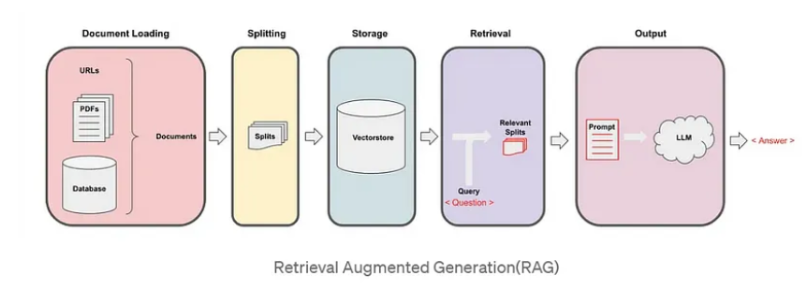

In [2]:
loader_un_sdg = PyPDFLoader("data/UN SDG.pdf")
documents_un_sdg = loader_un_sdg.load()
text_splitter_un_sdg = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=100)
text_un_sdg = text_splitter_un_sdg.split_documents(documents_un_sdg)

In [3]:

model_name = "BAAI/bge-large-en"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

hf = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

c:\Users\Administrator\miniconda3\envs\idk\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [5]:
from langchain_core.documents import Document

In [6]:
docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"},
    ),
    Document(
        page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...",
        metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2},
    ),
    Document(
        page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea",
        metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6},
    ),
    Document(
        page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them",
        metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3},
    ),
    Document(
        page_content="Toys come alive and have a blast doing so",
        metadata={"year": 1995, "genre": "animated"},
    ),
    Document(
        page_content="A hacker discovers reality is a simulation and leads a rebellion against the machines controlling it.",
        metadata={"year": 1999, "director": "Lana Wachowski, Lilly Wachowski", "rating": 8.7, "genre": "science fiction"},
    ),
    Document(
        page_content="A young lion prince flees his kingdom only to learn the true meaning of responsibility and bravery.",
        metadata={"year": 1994, "rating": 8.5, "genre": "animated"},
    ),
    Document(
        page_content="Batman faces off against the Joker, a criminal mastermind who plunges Gotham into chaos.",
        metadata={"year": 2008, "director": "Christopher Nolan", "rating": 9.0, "genre": "action"},
    ),
    Document(
        page_content="A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival.",
        metadata={"year": 2014, "director": "Christopher Nolan", "rating": 8.6, "genre": "science fiction"},
    )
]

In [ ]:
vectorstore = Chroma.from_documents(docs, hf)
     

In [ ]:
question1 = "Which 1994 animated movie has a rating of 8.5?"
     

question2 = "Which movie features Batman facing off against the Joker and who directed it?"
     

question3 = "What genre is the movie 'The Matrix' and who directed it?"

In [ ]:

vectorstore.similarity_search(question1)

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [7]:
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import  RunnableLambda,RunnablePassthrough

In [8]:
import textwrap 

def wrap_text(text,width=90):
    lines = text.split('\n')
    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text
     

In [ ]:

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
     

prompt = ChatPromptTemplate.from_template(template)

In [ ]:

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
text_reply = chain.invoke(question1)
     

print(wrap_text(text_reply))
     

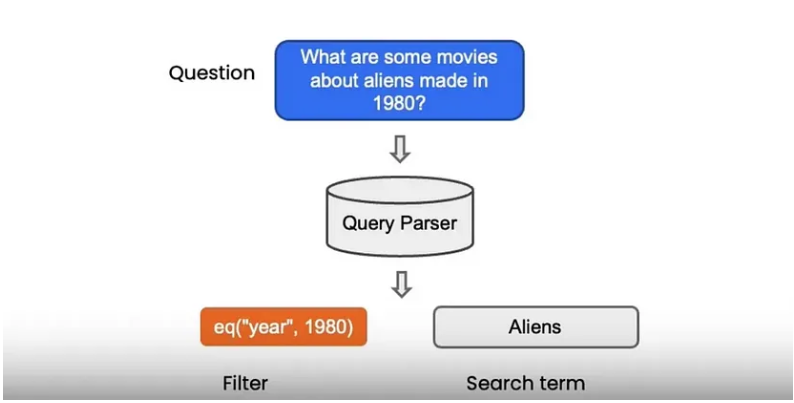

A self-query retriever is a retrieval system that can analyze a natural language question and use it to query itself. Here's how it works:

User Input: You provide a question in plain English. Understanding the Question: The retriever uses a large language model (LLM) to understand the intent and meaning behind your question.

Building a Structured Query: The LLM then translates your question into a structured query that a search engine can understand. This structured query might include keywords and filters based on the details you provided in your question.

Searching the Datastore: The retriever uses the structured query to search its underlying datastore, which is typically a vector store.

Returning Results: The retriever retrieves the documents from the datastore that are most relevant to your question.

We use metadata-filtering to filter out the important chunks.

When it can be used: It will be effective where you have to search in a small subset of the large document. Suppose you want to know about a particular department type like “Sales” in the whole document. Then you need to add this metadata info of department type in each chunk. And filter accordingly.

Overall, self-query retrieval is a powerful technique that leverages the capabilities of LLMs to achieve a more sophisticated and user-centric approach to information retrieval within LangChain models.

In [ ]:

from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="genre",
        description="The genre of the movie. One of ['science fiction', 'comedy', 'drama', 'thriller', 'romance', 'action', 'animated']",
        type="string",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating", description="A 1-10 rating for the movie", type="float"
    ),
]
     

In [ ]:

document_content_description = "Brief summary of a movie"
     

In [ ]:
from langchain.chains.query_constructor.base import (
    StructuredQueryOutputParser,
    get_query_constructor_prompt,
)

In [ ]:
prompt = get_query_constructor_prompt(
    document_content_description,
    metadata_field_info,
)

In [ ]:
!pip install lark

In [ ]:
output_parser = StructuredQueryOutputParser.from_components()
     

In [ ]:

query_constructor = prompt | llm | output_parser

In [ ]:

print(prompt.format(query="dummy question"))

In [ ]:

query_constructor.invoke(
    {
        "query": "What are some sci-fi movies from the 90's directed by Luc Besson about taxi drivers"
    }
)

In [ ]:
from langchain.retrievers.self_query.chroma import ChromaTranslator

retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vectorstore,
    structured_query_translator=ChromaTranslator(),
)

In [ ]:
retriever.invoke(
    "What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated"
)

In [ ]:
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

     


chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

text_reply = chain.invoke("Tell me about the movie which have rating more than 7.")

print(wrap_text(text_reply))

In [ ]:
text_reply = chain.invoke("Tell me about the movie which have rating more than 7.")

print(wrap_text(text_reply))